In [ ]:
from xml.dom import minidom
from urllib.request import urlopen
from urllib.request import urlretrieve

## Download all nc files (can take a while)

In [7]:
url = 'https://dapds00.nci.org.au/thredds/catalog/fx3/gbr1_2.0/catalog.xml'


In [19]:
def get_elements(url, tag_name, attribute_name):
    """Get elements from an XML file"""
    # usock = urllib2.urlopen(url)
    usock = urlopen(url)
    xmldoc = minidom.parse(usock)
    usock.close()
    tags = xmldoc.getElementsByTagName(tag_name)
    attributes=[]
    for tag in tags:
        attribute = tag.getAttribute(attribute_name)
        attributes.append(attribute)
    return attributes
 

catalog = get_elements(url,'dataset','urlPath')
files=[]
for citem in catalog:
    if (citem[-3:]=='.nc'):
        files.append(citem)

count = 0
for f in files:
    count +=1
    file_url = 'https://dapds00.nci.org.au/thredds/' + 'fileServer/' + f
    file_prefix = file_url.split('/')[-1][:-3]
    file_name = file_prefix + '_' + str(count) + '.nc'
    print('Downloaing file %d of %d' % (count,len(files)))
    print(file_name)
    a = urlretrieve(file_url,file_name)
    print(a)


## Get a subset of data and load into python and save

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from siphon import catalog, ncss
import datetime

url = 'https://dapds00.nci.org.au/thredds/catalog/fx3/gbr1_2.0/catalog.xml'
tds = catalog.TDSCatalog(url)
dts = tds.datasets


In [3]:
# change dates here
date_start = "2016-12-01"
date_end = "2017-01-01"
for i in range(1,len(dts)):
    if date_start in dts[i].name:
        index_start = i
    if date_end in dts[i].name:
        index_end = i
    

In [5]:
[index_start,index_end]

range(5, 2, -1)

In [7]:
import xarray as xr

def get_data(dataset, bbox, var):
    nc = ncss.NCSS(dataset.access_urls['NetcdfSubset'])
    query = nc.query()
    query.all_times()#all times
    query.lonlat_box(north=bbox[0],south=bbox[1],east=bbox[2],west=bbox[3])
    query.variables(*var)
    query.add_query_parameter(vertCoord = 1.5)#surface
    query

    data = nc.get_data(query)
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
    return ds

bbox = [-10,-11,145,144]#select box
var = ['temp']#select var

# for time, change the i indices, right now, it gets all first time indices
for i in range(index_start,index_end,-1):#range(1,len(dts)+1):
    ds = get_data(dts[i],bbox,var)
    if i != index_start:
        data = xr.concat([data,ds],dim = 'time')
    else:
        data = ds
    print(str(i) + '/ ' + str(len(dts)+1)) 
    
# fix dimensions    
data['longitude'] = data.longitude[1,:]
data['latitude'] = data.latitude[:,1]
data = data.swap_dims({'j':'latitude','i':'longitude','k':'zc'})    
    
data


1571/ 2345
1570/ 2345
1569/ 2345
1568/ 2345
1567/ 2345
1566/ 2345
1565/ 2345
1564/ 2345
1563/ 2345
1562/ 2345
1561/ 2345
1560/ 2345
1559/ 2345
1558/ 2345
1557/ 2345
1556/ 2345
1555/ 2345
1554/ 2345
1553/ 2345
1552/ 2345
1551/ 2345
1550/ 2345
1549/ 2345
1548/ 2345
1547/ 2345
1546/ 2345
1545/ 2345
1544/ 2345
1543/ 2345
1542/ 2345
1541/ 2345


<xarray.Dataset>
Dimensions:    (time: 744, zc: 1, latitude: 115, longitude: 112)
Coordinates:
  * time       (time) datetime64[ns] 2016-11-30T14:00:00 ... 2016-12-31T12:59...
  * zc         (zc) float64 1.5
  * latitude   (latitude) float64 -10.99 -10.99 -10.98 ... -9.787 -9.774 -9.761
  * longitude  (longitude) float64 143.9 143.9 143.9 143.9 ... 144.7 144.7 144.7
Data variables:
    temp       (time, zc, latitude, longitude) float32 27.52 27.56 ... nan nan
Attributes: (12/13)
    hasVocab:            1
    metadata_link:       http://marlin.csiro.au/geonetwork/srv/eng/search?&uu...
    title:               GBR1 Hydro
    paramhead:           GBR 1km resolution grid
    paramfile:           prm/gbr1_pear.prm
    shoc_version:        v1.1 rev(5553)
    ...                  ...
    Run_ID:              2.0
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  -11.03812
    geospatial_lat_max:  -9.759306
    geospatial_lon_min:  143.911974
    geospatial_lon_max:  144.980469

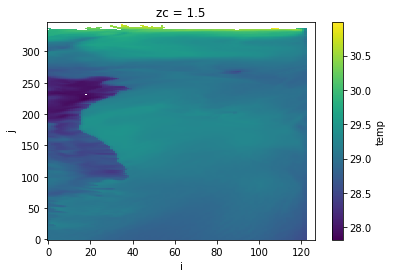

In [31]:
data.temp.isel(zc = -1).mean(dim = 'time').plot()

In [6]:
#save as nc
data.to_netcdf('example.nc')